In [1]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [3]:
ppo = parse_tensorboard(path='./output_malota/PPO_8', scalars=['rollout/ep_rew_mean'])

In [13]:
models = {
    'PPO_MlpPolicy': parse_tensorboard(path='./output_malota/PPO_8', scalars=['rollout/ep_rew_mean']),
    'PPO_Attention_TrXL': parse_tensorboard(path='./output_malota/PPO_60', scalars=['rollout/ep_rew_mean']),
    'PPO_SPCA': parse_tensorboard(path='./output_malota/PPO_64', scalars=['rollout/ep_rew_mean']),
    'PPO_PCA': parse_tensorboard(path='./output_malota/PPO_31', scalars=['rollout/ep_rew_mean'])
    
}

Text(0.5, 1.0, 'Średnia nagroda za epizod podczas uczenia')

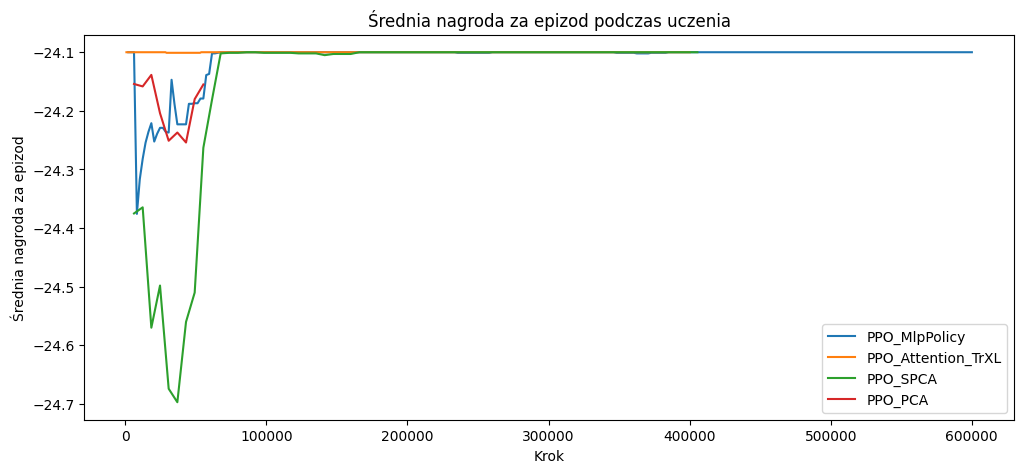

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for model, data in models.items():
    plt.plot(data['rollout/ep_rew_mean']['step'], data['rollout/ep_rew_mean']['value'])

plt.legend(list(models.keys()))
plt.xlabel("Krok")
plt.ylabel("Średnia nagroda za epizod")
plt.title("Średnia nagroda za epizod podczas uczenia")

In [19]:
models = {
    'PPO_MlpPolicy': parse_tensorboard(path='./output_malota/PPO_8', scalars=['rollout/ep_rew_mean']),
    'PPO_3_cechy_wejściowe_Attention': parse_tensorboard(path='./output_malota/PPO_70', scalars=['rollout/ep_rew_mean']),
    'PPO_3_cech_wejściowe_SPCA': parse_tensorboard(path='./output_malota/PPO_72', scalars=['rollout/ep_rew_mean'])
}

Text(0.5, 1.0, 'Średnia nagroda za epizod podczas uczenia')

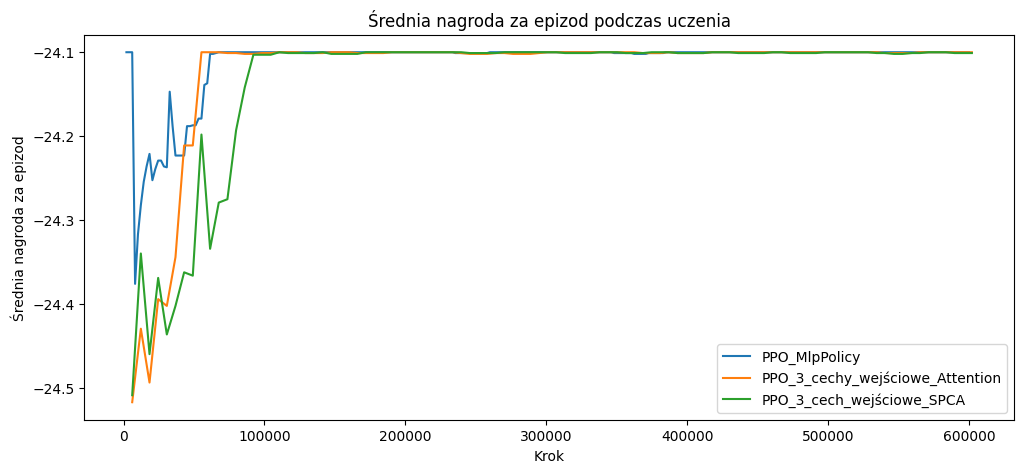

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for model, data in models.items():
    plt.plot(data['rollout/ep_rew_mean']['step'], data['rollout/ep_rew_mean']['value'])

plt.legend(list(models.keys()))
plt.xlabel("Krok")
plt.ylabel("Średnia nagroda za epizod")
plt.title("Średnia nagroda za epizod podczas uczenia")

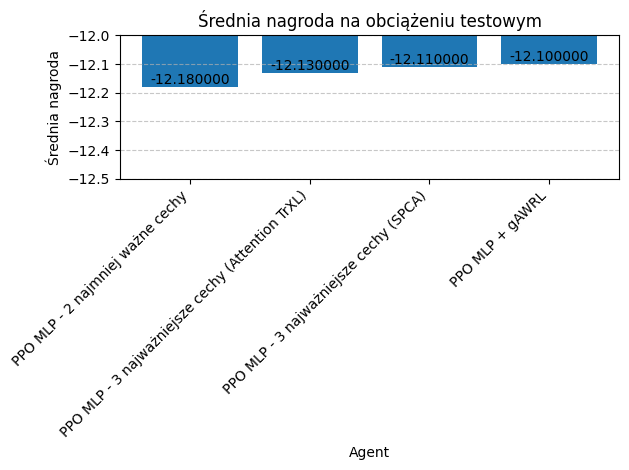

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [r'C:\initial_model\historic_3\ppo_masked_PPO_73_worst_features\ppo_MlpPolicy_mlp_600_000_masked_3_worst_features.csv', 
                 r'C:\initial_model\eval_results\ppo_MlpPolicy_mlp_600_000_masked_3_test_dnnevo.csv', 
                 r'C:\initial_model\historic_3\ppo_masked_PPO_72_SPCA\TEST-DNNEVO\ppo_MlpPolicy_mlp_600_000_masked_3_spca_based.csv',
                 r'C:\initial_model\historic_3\gawrl_old_PPO_1\TEST-DNNEVO\attention_MlpPolicy_mlp_gawrl_viz.csv'
                 ]  # Example paths
labels = ['PPO MLP - 2 najmniej ważne cechy', 'PPO MLP - 3 najważniejsze cechy (Attention TrXL)', 'PPO MLP - 3 najważniejsze cechy (SPCA)', 'PPO MLP + gAWRL']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of paths to DataFrame files
list_of_paths = [
                 r'C:\initial_model\historic_3\gawrl_old_PPO_1\TEST-DNNEVO\attention_MlpPolicy_mlp_gawrl_viz.csv'
                 ]  # Example paths
labels = ['PPO MLP - 2 najmniej ważne cechy', 'PPO MLP - 3 najważniejsze cechy (Attention TrXL)', 'PPO MLP - 3 najważniejsze cechy (SPCA)', 'PPO MLP + gAWRL']
means = []
#labels = []

for path in list_of_paths:
    df = pd.read_csv(path)  # Adjust read function if necessary (e.g., pd.read_parquet)
    mean_rew = df['rew'].mean()
    means.append(mean_rew)
    labels = labels
    #labels.append(path.split('/')[-1])  # Use filename as label
# Create bar plot
x_pos = np.arange(len(labels))
bars = plt.bar(x_pos, means)

# Set y-axis limits to focus on the range of interest
plt.ylim(-12.5, -12)

# Add value labels on top of each bar
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{mean_val:.6f}',  # Format to 6 decimal places for precision
             ha='center', va='bottom', rotation=0)

plt.xlabel('Agent')
plt.ylabel('Średnia nagroda')
plt.title('Średnia nagroda na obciążeniu testowym')
plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.tight_layout()

# Add a horizontal grid for better reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
